# Разработка сентимент-анализа под задачу заказчика

## импорт

In [290]:
import pandas as pd
from time import sleep
import sys
import requests
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from itertools import product
import warnings

## загрузка данных для теста

In [291]:
with open('test.csv', 'r', encoding='utf-8') as test_file:
    test_content = test_file.read()

In [292]:
df_test = pd.DataFrame({
    'text': [
        r.strip() for r in
        test_content.replace('<review>', '').replace('</review>', '').split('\n\n\n')
        if r.strip() != ''
    ]
}) 

In [293]:
print('\n\n\n'.join(df_test.sample(n=5).text))

Абалденно долго держит зарядку, устойчив к ударам, простой и понятный интерфейс и их еще много
Очень долго думала, прежде чем купить себе телефон с кверти клавиатурой. Мне казался он безумно не удобным. У меня был сенсорный LG, который дико надоел со своими постоянными глюками и в итоге я решила купить себе "рабочий" телефон. Купила белый Аша200. С самой первой минуты как мне показал его продавец, он понравился мне. Во первых очень удобно лежит в руке. Цвет я купила белый, вопреки своему же принципу) И ничуть не жалею, за год использования ему не сделалось почти ничего! Учитывая, что он несколько раз падал то на пол то на асфальт, но это по моей неосторожности. Моё мнение о неудобстве кверти клавиатуры развеялось на следующий же день. Не было желания выпускать его из рук. Про зарядку это просто без комментариев! После первой зарядки я не включала его в сеть 9 дней!!! Достоинств у телефона вагон! Орет громко, инет есть(конечно не такой как в смартфонах, но при необходимости нормально), 

## Сбор тренировочных данных
Нетрудно догадаться, что речь идёт об отзывах на телефоны. Соберём тренировочный датасет с сайта: https://hi-tech.mail.ru

In [294]:
url = 'https://hi-tech.mail.ru/mobile-catalog/'
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36'
}
req = requests.get(url, headers=headers)
parser = BeautifulSoup(req.content.decode(), 'html.parser')

In [295]:
%%time
last_page_tag = parser.find('a', attrs={'class': 'paging__link paging__link_last js-paging__page'})
last_page = int(last_page_tag.text)
catalog_links = [f'https://hi-tech.mail.ru/mobile-catalog/?page={p}' for p in range(1, last_page+1)]

def get_phone_links(url):
    req = requests.get(url, headers=headers)
    parser = BeautifulSoup(req.content.decode(), 'html.parser')
    phone_tags = parser.find_all('a', attrs={'class': 'p-catalog-card__link link-holder'})
    return [f'https://hi-tech.mail.ru{t["href"]}otzyvy/' for t in phone_tags]

phone_links = list()
counter = 1
for cl in catalog_links:
    phone_links += get_phone_links(cl)
    sleep(1)
    sys.stdout.write('progress: %.3f%%\r' % (counter/last_page*100))
    counter += 1
print()

progress: 100.000%
Wall time: 2min 18s


In [296]:
%%time

errors = {
    'get_url': list(),
    'find_cards': list(),
    'get_review_info': list()
}

def get_reviews(url):
    global errors
    reviews = list()
    try:
        req = requests.get(url, headers=headers)
        parser = BeautifulSoup(req.content.decode(), 'html.parser')
    except Exception as e:
        errors['get_url'].append(str(e))

    try:
        cards = parser.find_all('span', attrs={'class': 'card__text'})
    except Exception as e:
        errors['find_cards'].append(str(e))

    for card in cards:
        try:
            rate = int(card.find('div', attrs={'class': 'p-model-review__stars'}).text)
            review = '\n'.join([s.text for s in card.find_all('span', attrs={'class': 'text margin_top_10'})])
            reviews.append((rate, review))
        except Exception as e:
            errors['get_review_info'].append(str(e))

    return reviews

counter = 1
total = len(phone_links)
reviews = list()
for pl in phone_links:
    reviews += get_reviews(pl)
    sleep(0.1)
    sys.stdout.write('progress: %.3f%%\r' % (counter/total*100))
    counter += 1
print()

progress: 100.000%
Wall time: 40min 34s


In [297]:
transformed_reviews = list(zip(*reviews))
df_train_raw = pd.DataFrame({
    'text': transformed_reviews[1],
    'rating': transformed_reviews[0]
})
df_train_raw.to_csv('train.tsv', sep='\t', index=False)

In [298]:
df_train_raw.sample(n=5)

,text,rating
8169,"Экран супер,дизайн отличный, удобный! \nАккуму...",5
6611,"Мощный (4/64), HD экран, недорогой, оболочка F...",5
8157,"Цена ниже конкурентов\r\nМеталлический, компак...",4
6254,"Телефон уже полтора года,работает шустро,не ту...",5
5576,"Отлично ловит связь, 2 Sim, Инфракрасный порт ...",5


In [299]:
df_train_raw.rating.value_counts()

5    6584
4    1682
3     650
1     606
2     330
Name: rating, dtype: int64

Телефоны оцениваются по 5-бальной шкале. Преобразуем данные следующим образом. Выкинем тройку как нейтральную оценку, 1 и 2 будем считать отрицательным отзывом, 4 и 5 - положительным

In [307]:
df1 = df_train_raw[df_train_raw.rating.isin([4,5])]
df1.rating = df1.rating.apply(lambda r: 1)
df2 = df_train_raw[df_train_raw.rating.isin([1,2])]
df2.rating = df2.rating.apply(lambda r: 0)
df_train = pd.concat((df1, df2)).reset_index(drop=True)
df_train.rating.value_counts()

1    8266
0     936
Name: rating, dtype: int64

Классы получились явно не сбалансированы. Сделаем undersampling первого класса.

In [308]:
neg_number = df_train[df_train.rating==0].shape[0]
df_train_balanced = pd.concat((
    df_train[df_train.rating==0],
    df_train[df_train.rating==1].sample(n=neg_number, random_state=42)
)).reset_index(drop=True)

In [309]:
df_train_balanced.rename(columns={'rating': 'label'}, inplace=True)
df_train_balanced.label.value_counts()

0    936
1    936
Name: label, dtype: int64

## Подбор модели

In [315]:
def text_classifier(vectorizer, classifier):
    return Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier)
    ])

def progress(total):
    for i in range(1, total+1):
        sys.stdout.write('progress: %.3f%%\r' % (i/total*100))
        yield
    print()

In [316]:
random_state = 42

vectorizers = (
    CountVectorizer(),
    CountVectorizer(ngram_range=(1,2)),
    CountVectorizer(ngram_range=(1,3)),
    CountVectorizer(ngram_range=(2,5), analyzer='char_wb'),
    CountVectorizer(ngram_range=(3,10), analyzer='char_wb'),
    TfidfVectorizer(),
    TfidfVectorizer(ngram_range=(1,2)),
    TfidfVectorizer(ngram_range=(1,3)),
    TfidfVectorizer(ngram_range=(2,5), analyzer='char_wb'),
    TfidfVectorizer(ngram_range=(3,10), analyzer='char_wb'),
)

classifiers = (
    LogisticRegression(random_state=random_state),
    LinearSVC(random_state=random_state)
)

raw_models = list()
for vec, clf in product(vectorizers, classifiers):
    raw_models.append(text_classifier(vec, clf))
models = pd.DataFrame({
    'model': raw_models
})

In [320]:
%%time

pr = progress(models.shape[0])

def calculate_accuracy(model):
    score = cross_val_score(
        model, df_train_balanced.text, df_train_balanced.label, scoring='accuracy'
    ).mean()
    next(pr)
    return score

warnings.filterwarnings('ignore')
models['score'] = models.model.apply(calculate_accuracy)
print()
warnings.filterwarnings('default')

progress: 100.000%
Wall time: 6min 40s


In [322]:
for _, row in models.sort_values('score', ascending=False).iterrows():
    print('accuracy: %.3f' % row.score)
    print(row.model['vectorizer'])
    print(row.model['classifier'])
    print('--------------------------------------------------------')

accuracy: 0.869
TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 10))
LogisticRegression(random_state=42)
--------------------------------------------------------
accuracy: 0.866
TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 5))
LogisticRegression(random_state=42)
--------------------------------------------------------
accuracy: 0.862
TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 5))
LinearSVC(random_state=42)
--------------------------------------------------------
accuracy: 0.861
TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 10))
LinearSVC(random_state=42)
--------------------------------------------------------
accuracy: 0.844
CountVectorizer(analyzer='char_wb', ngram_range=(3, 10))
LogisticRegression(random_state=42)
--------------------------------------------------------
accuracy: 0.841
TfidfVectorizer()
LinearSVC(random_state=42)
--------------------------------------------------------
accuracy: 0.841
TfidfVectorizer()
LogisticRegression(random_state=42)
--

Наилучшие результаты на кросс валидации показывает логистическая регрессия с TfIdf и буквенными н-граммами. Но на тестовых данных, (после проверки на kaggle), лучше всего себя показал baseline: TfidfVectorizer() + LinearSVC(random_state=42)


## Обучение финальной модели

In [323]:
model = text_classifier(
    TfidfVectorizer(),
    LinearSVC(random_state=random_state)
)
model.fit(df_train_balanced.text, df_train_balanced.label)
df_test['y'] = model.predict(df_test.text)
df_test['y'] = df_test['y'].apply(lambda y: 'pos' if y==1 else 'neg')
df_test[['y']].to_csv('submission.csv', sep=',', index_label='Id')

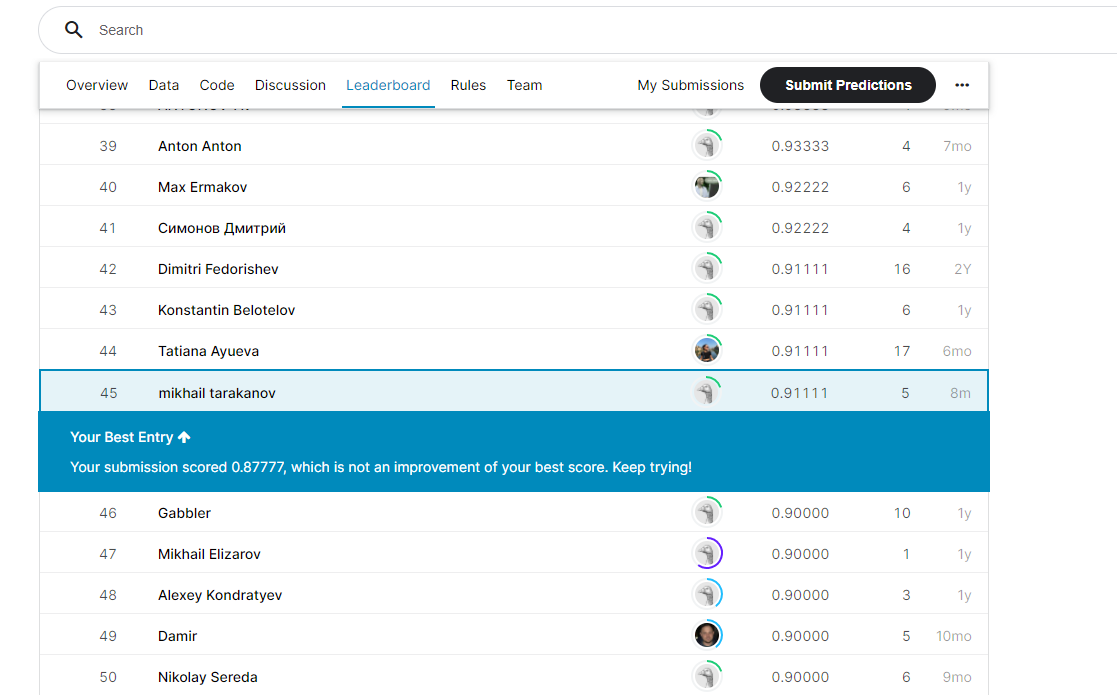

In [324]:
from IPython.display import Image
Image("leaderboard.png")